In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import random as rd

#### 初始化常量

In [2]:
sources_path = "../CoreML/flower_photos/"
split_rate = 0.2
categories = glob.glob(sources_path + "*")
category_names = [x.split("/")[-1] for x in categories]
categories_count = len(category_names)
print "category_names:%s"%category_names
log_path = "logs/"
checkpoint_path = "logs/model.ckpt"

category_names:['daisy_0', 'sunflowers_3', 'roses_2', 'dandelion_1', 'tulips_4']


#### 本地文件读取数据

In [3]:
def readData():
    train_image_paths = []
    test_image_paths = []
    for path in categories:
        image_paths = glob.glob(path + "/*.jpg")
        split_count = int(len(image_paths) * (1 - split_rate))
        train_image_paths += image_paths[:split_count]
        test_image_paths += image_paths[split_count:]

    train_labels = [x.split("/")[-2] for x in train_image_paths]
    test_labels = [x.split("/")[-2] for x in test_image_paths]
    train_label_list = [x.split("_")[1] for x in train_labels]
    test_labels_list = [x.split("_")[1] for x in test_labels]

    train_image_paths = np.asarray(train_image_paths)
    train_labels = np.asarray(train_labels)
    test_image_paths = np.asarray(test_image_paths)
    test_labels = np.asarray(test_labels)

    return (train_image_paths, train_label_list), (test_image_paths, test_labels_list)

#### 图片预览

In [4]:
def view_images(images,labels,count):
    sess = tf.Session() 
    ax = plt.figure(figsize=(10, 10))
    for i in range(count):
        ax.add_subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,:], cmap=plt.cm.binary)
        index= tf.argmax(labels[i])                  
        plt.xlabel([x for i,x in enumerate(category_names) if x.find(str(sess.run(index))) != -1][0])
    plt.show()

### 生成器，用于生产训练数据
- Returns:训练需要的数据

In [5]:
keep_prob = tf.placeholder(tf.float32)

batch_size = 50
learning_rate = 0.003
image_size = 64

x = tf.placeholder("float",shape=[None,image_size,image_size,3])
y = tf.placeholder("int32",shape=[None,categories_count])

In [6]:
def parse_data(dataset):
    
    image = dataset[0]
    label = dataset[1]
    
    image_contents = tf.read_file(tf.cast(image,tf.string))
    image = tf.image.decode_jpeg(image_contents, channels=3)
    image = tf.image.resize_image_with_pad(image,image_size,image_size)
    image = tf.image.per_image_standardization(image)
    
    label = tf.string_to_number(label,out_type=tf.int32,name=None)
    label = tf.one_hot(label,depth=categories_count)
    label = tf.cast(label,dtype=tf.uint8)
    
    return (image,label)

In [7]:
def get_batch(image, label, batch_size):
    
    source_set = np.asarray([image, label]).T
    source_set_tf = tf.cast(source_set, tf.string)
    
    dataset = tf.data.Dataset.from_tensor_slices(source_set_tf)
    dataset = dataset.map(parse_data)
    dataset = dataset.shuffle(1000)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

#### 模型定义

In [8]:
def inference(images, n_classes):
    
    ## 第一层卷积 
    w_conv1 = tf.Variable(tf.truncated_normal([3,3,3,16],stddev=0.1))
    b_conv1 = tf.Variable(tf.constant(0.1,shape=[16]))
    y_conv1 = tf.nn.conv2d(images,w_conv1,strides=[1,1,1,1], padding="SAME") + b_conv1
    h_conv1 = tf.nn.relu(y_conv1)
    h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,3,3,1],strides=[1,2,2,1], padding="SAME")
    
    ## 第二层卷积
    w_conv2 = tf.Variable(tf.truncated_normal([3,3,16,64],stddev=0.1))
    b_conv2 = tf.Variable(tf.constant(0.1,shape=[64]))
    y_conv2 = tf.nn.conv2d(h_pool1,w_conv2,strides=[1,1,1,1], padding="SAME") + b_conv2
    h_conv2= tf.nn.relu(y_conv2)
    h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,1,1,1], padding="SAME")
    h_pool2_flat = tf.reshape(h_pool2,[batch_size,-1])
    
    ## 全连接层  /2是因为第一层卷积步长为2
    w_fc1 = tf.Variable(tf.truncated_normal([(image_size/2)**2*64,128],stddev=0.005))
    b_fc1 = tf.Variable(tf.constant(0.1,shape=[128]))
    y_fc1 = tf.matmul(h_pool2_flat, w_fc1) + b_fc1
    h_fc1 = tf.nn.relu(y_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)
    
    ## 全连接层
    w_fc2 = tf.Variable(tf.truncated_normal([128,512],stddev=0.005))
    b_fc2 = tf.Variable(tf.constant(0.005,shape=[512]))
    y_fc2 = tf.matmul(h_fc1_drop, w_fc2) + b_fc2
    h_fc2= tf.nn.relu(y_fc2)
    h_fc2_drop = tf.nn.dropout(h_fc1,keep_prob)
    
    ## 全连接输出层
    w_fc3 = tf.Variable(tf.truncated_normal([128,n_classes],stddev=0.005))
    b_fc3 = tf.Variable(tf.constant(0.005,shape=[n_classes]))
    y_fc3 = tf.matmul(h_fc2_drop, w_fc3) + b_fc3
    
    return y_fc3


def losses(logits, labels):
    with tf.variable_scope('loss') as scope:
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2 \
            (logits=logits, labels=labels, name='xentropy_per_example')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name + '/loss', loss)
    return loss


def trainning(loss, learning_rate):
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op


def evaluation(logits, labels):
    with tf.variable_scope('accuracy') as scope:
        
        labels = tf.map_fn(lambda x:tf.cast(tf.argmax(x),dtype=tf.int32), labels)
        correct = tf.nn.in_top_k(logits, labels, 1)
        correct = tf.cast(correct, tf.float16)
        accuracy = tf.reduce_mean(correct)
        tf.summary.scalar(scope.name + '/accuracy', accuracy)
    return accuracy

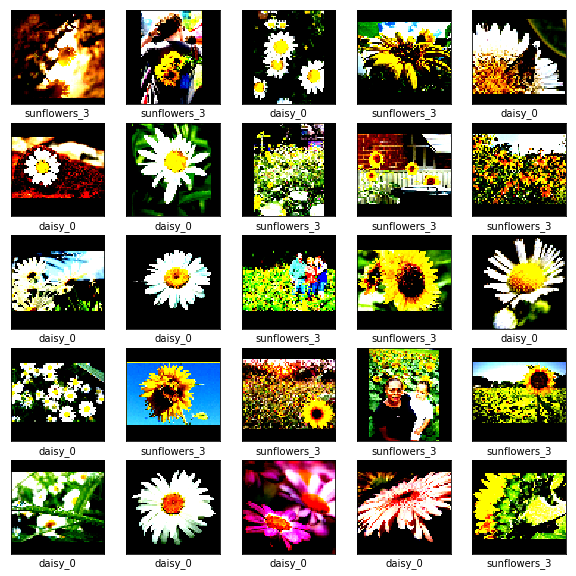

Step 0,train loss = 1.61,train occuracy = 20.00%


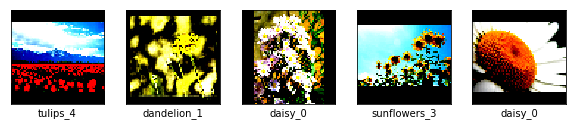

Save point: test occuracy = 14.00%


In [ ]:
(train, label), (test, testLabel) = readData()

iterator = get_batch(train,label,batch_size)
next_element = iterator.get_next()

test_iterator = get_batch(test,testLabel,batch_size)
test_element = test_iterator.get_next()

train_logits = inference(x, categories_count)
train_loss = losses(train_logits, y)
train_op = trainning(train_loss, learning_rate)
train_acc = evaluation(train_logits, y)

with tf.Session() as sess:
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_path, sess.graph)
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer)
    sess.run(test_iterator.initializer)
    try:
        for step in range(5000):
            
            train_images,labels = sess.run(next_element)
            
            if step == 0:
                ##预览图片
                view_images(train_images,labels,25);
            
            _, tra_loss, tra_acc = sess.run([train_op, train_loss, train_acc], feed_dict = {x:train_images, y:labels, keep_prob:0.5})
            if step % 100 == 0:
                print('Step %d,train loss = %.2f,train occuracy = %.2f%%' % (step, tra_loss, tra_acc*100))
                summary_str = sess.run(summary_op, feed_dict = {x:train_images, y:labels, keep_prob:0.5})
                train_writer.add_summary(summary_str, step)
                if step % 1000 == 0 or (step + 1) == 5000:
                    test_images,test_labels = sess.run(test_element)
                    view_images(test_images,test_labels,5);
                    test_acc = sess.run(train_acc, feed_dict = {x:test_images, y:test_labels, keep_prob:0.5})
                    print('Save point: test occuracy = %.2f%%'%(test_acc*100))
                    saver.save(sess, checkpoint_path, global_step=step)    
    except tf.errors.OutOfRangeError:
        print('Done training epoch limit reached')
    finally:
        print('Done!')
  